In [1]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Philippa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Philippa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Philippa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Philippa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Philippa\AppData\Roaming

True

## Sentiment Analysis with BERT

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [97]:
# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [98]:
# reimport the data
df_NL = pd.read_csv(r"C:\Users\Philippa\Documents\GitHub\webscraper\Scraper\NL_Parsed_Reviews.csv")

df_NL

,name,date,rating,review
0,Ughduty,"Jun 19, 2025",7,Never played the game. Metacritic assigned my ...
1,tarquinthegreat,"Apr 28, 2025",10,absolutely banging ‎xxxxxxxxxxxxxxxxxxxxxxxxxx...
2,Gamewing,"Apr 21, 2025",6,"First couple hours are fun, getting your first..."
3,Z4ry,"Mar 24, 2025",9,100+ hours\n- Great evolution from previous ti...
4,Lucaq,"Mar 20, 2025",10,Perfect in every way.\nAaaaaaaaaaaaaaaaaaaaaaa...
...,...,...,...,...
209,Autosaver,"Jun 9, 2013",10,Animal Crossing has gone a long way since the ...
210,KirkyDaTurkey,"Jun 9, 2013",9,"Based on Day 1, this game is definitely a 9 so..."
211,EFYevan,"Jun 9, 2013",10,Much different than the previous DS version I...
212,L0stR3negade,"Jun 9, 2013",9,Refreshing style of game to play. Its hard to ...


In [99]:
# double check if there are any missing values
df_NL.isnull().sum()

name      0
date      0
rating    0
review    0
dtype: int64

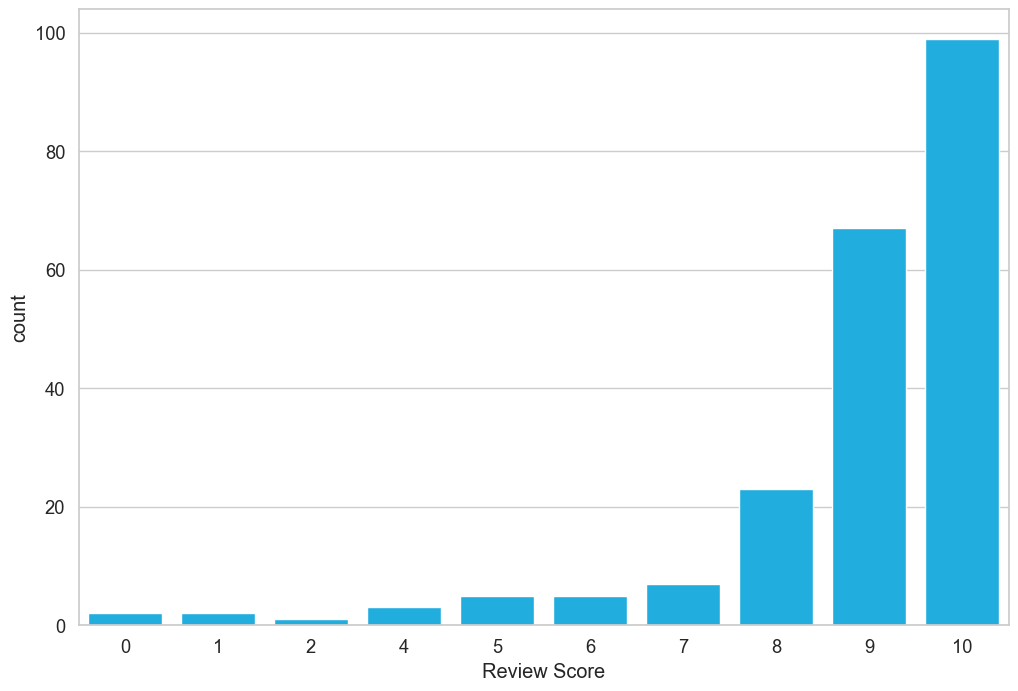

In [100]:
# look at the class balance
sns.countplot(df_NL, x="rating")
plt.xlabel("Review Score");

There are a lot more positive classes compared to negative classes. It doesn't seem like anyone gave this game a score of 3.

I'll define the rating scores as positive, negative, or neutral classes.
* Negative (Score: 0 - 4)
* Neutral (Score: 5)
* Positive (Score: 6 - 10)

In [101]:
def to_sentiment(rating):
    rating = int(rating)
    
    if rating <= 4:
        return 0
    elif rating == 5:
        return 1
    else:
        return 2
    
# apply scoring to dataset
df_NL["sentiment"] = df_NL["rating"].apply(to_sentiment)
df_NL

,name,date,rating,review,sentiment
0,Ughduty,"Jun 19, 2025",7,Never played the game. Metacritic assigned my ...,2
1,tarquinthegreat,"Apr 28, 2025",10,absolutely banging ‎xxxxxxxxxxxxxxxxxxxxxxxxxx...,2
2,Gamewing,"Apr 21, 2025",6,"First couple hours are fun, getting your first...",2
3,Z4ry,"Mar 24, 2025",9,100+ hours\n- Great evolution from previous ti...,2
4,Lucaq,"Mar 20, 2025",10,Perfect in every way.\nAaaaaaaaaaaaaaaaaaaaaaa...,2
...,...,...,...,...,...
209,Autosaver,"Jun 9, 2013",10,Animal Crossing has gone a long way since the ...,2
210,KirkyDaTurkey,"Jun 9, 2013",9,"Based on Day 1, this game is definitely a 9 so...",2
211,EFYevan,"Jun 9, 2013",10,Much different than the previous DS version I...,2
212,L0stR3negade,"Jun 9, 2013",9,Refreshing style of game to play. Its hard to ...,2


C:\Users\Philippa\AppData\Local\Temp\ipykernel_35904\3302368973.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

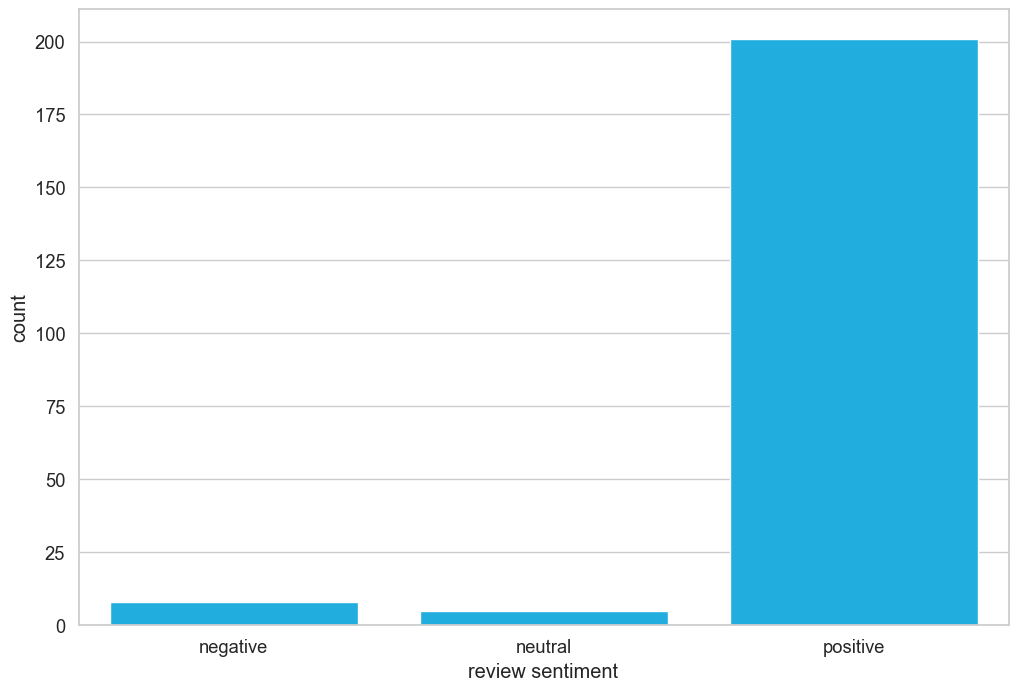

In [102]:
# plotting the distribution
class_names = ["negative", "neutral", "positive"]
ax = sns.countplot(df_NL, x="sentiment")
plt.xlabel("review sentiment")
ax.set_xticklabels(class_names)

### Data Preprocessing

In [103]:
# setting the model name
MODEL_NAME = "bert-base-cased"

# BERT-based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [104]:
## Common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows it's classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [105]:
# BERT works with fixed-length sequences. use a simple strategy to choose max length
# store length of each review
token_lens = []

# iterate through the content slide
for txt in df_NL["review"]:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 16.044444444444423, 'Token count')

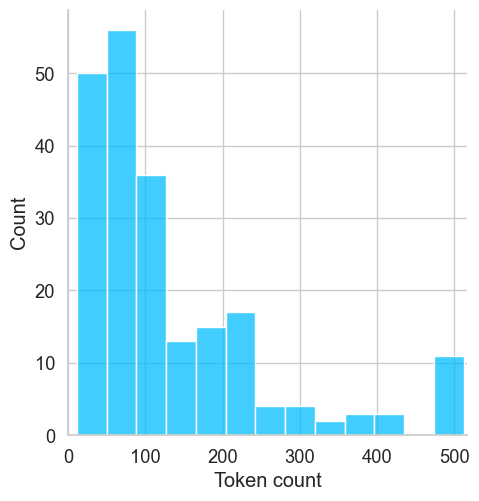

In [106]:
sns.displot(token_lens)
plt.xlim([0, 516]);
plt.xlabel("Token count")

Most of the reviews contain 200 tokens or less, but some contain up to 500. To be safe and encompass everything, the maximum length can be set to 512 (hard to tell on the graph if its less or more than 500).

In [107]:
MAX_LEN = 512

## Preparing Torch Dataset

In [108]:
class MCReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # Get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [109]:
# create an 80% training data, 10% test data set, and 10% validation data set
df_train, df_test = train_test_split(df_NL, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(171, 5) (21, 5) (22, 5)


In [110]:
# create a dataloader to release data in batches
def create_dataloader(df, tokenizer, max_len, batch_size):
    ds = MCReviewDataset(
        reviews=df["review"].to_numpy(),
        targets=df["sentiment"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [111]:
# create train, test, and val DataLoaders
BATCH_SIZE = 16
train_dataloader = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [112]:
# Examples
data = next(iter(train_dataloader))
print(data.keys())

print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [113]:
# Load in basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [114]:
# sentiment classifier class
class SentimentClassifier(nn.Module):
    
    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3) # dropout layer for some regularization
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    # forward propagation class
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output   
        output = self.drop(pooled_output)
        return self.out(output)

In [133]:
# instatiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)
print(next(model.parameters()).device)

cuda:0


In [116]:
## model characteristics
print(bert_model.config.hidden_size)

768


### Training Phase

In [134]:
EPOCHS = 10

# optimizer Adam
optimizer = transformers.Adafactor(params=model.parameters(), lr=0.001, relative_step=False)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
     optimizer,
     num_warmup_steps=0,
     num_training_steps=total_steps
 )

# set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [135]:
# function for a single training iteration

def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer,
                device,
                scheduler,
                n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        
        ## gradient descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [136]:
# function to evaluate model performance
def eval_model(model,
               data_loader,
               loss_fn,
               device,
               n_examples):
    
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.inference_mode():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # get model outputs
            outputs = model(
                input_ids = input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [137]:
from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch + 1} / {EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_step(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss: {train_loss} | Accuracy: {train_acc}")
    
    # model performance (acc and loss)
    val_acc, val_loss = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val loss: {val_loss} | Val acc: {val_acc}")
    print()
    
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10
----------
Train loss: 0.6881292679093101 | Accuracy: 0.7777777777777777
Val loss: 0.21908240020275116 | Val acc: 0.9523809523809523



 10%|█         | 1/10 [00:32<04:53, 32.57s/it]

Epoch 2 / 10
----------
Train loss: 0.3270449949936433 | Accuracy: 0.935672514619883


 20%|██        | 2/10 [01:00<03:58, 29.78s/it]

Val loss: 0.15095425583422184 | Val acc: 0.9523809523809523

Epoch 3 / 10
----------
Train loss: 0.294376593421806 | Accuracy: 0.935672514619883


 30%|███       | 3/10 [01:28<03:23, 29.04s/it]

Val loss: 0.1529972879216075 | Val acc: 0.9523809523809523

Epoch 4 / 10
----------
Train loss: 0.28793065961111675 | Accuracy: 0.935672514619883


 40%|████      | 4/10 [01:57<02:53, 28.90s/it]

Val loss: 0.15089498739689589 | Val acc: 0.9523809523809523

Epoch 5 / 10
----------
Train loss: 0.2744896063073115 | Accuracy: 0.935672514619883


 50%|█████     | 5/10 [02:25<02:23, 28.71s/it]

Val loss: 0.14721732586622238 | Val acc: 0.9523809523809523

Epoch 6 / 10
----------
Train loss: 0.2554403137076985 | Accuracy: 0.935672514619883


 60%|██████    | 6/10 [02:54<01:54, 28.64s/it]

Val loss: 0.15307820867747068 | Val acc: 0.9523809523809523

Epoch 7 / 10
----------
Train loss: 0.23524091392755508 | Accuracy: 0.935672514619883


 70%|███████   | 7/10 [03:22<01:25, 28.63s/it]

Val loss: 0.15621864795684814 | Val acc: 0.9523809523809523

Epoch 8 / 10
----------
Train loss: 0.21418661785058 | Accuracy: 0.935672514619883


 80%|████████  | 8/10 [03:50<00:56, 28.28s/it]

Val loss: 0.16166389919817448 | Val acc: 0.9523809523809523

Epoch 9 / 10
----------
Train loss: 0.20082124932245773 | Accuracy: 0.935672514619883


 90%|█████████ | 9/10 [04:15<00:27, 27.35s/it]

Val loss: 0.16671924851834774 | Val acc: 0.9523809523809523

Epoch 10 / 10
----------
Train loss: 0.172601162455976 | Accuracy: 0.935672514619883


100%|██████████| 10/10 [04:41<00:00, 28.13s/it]

Val loss: 0.1693876702338457 | Val acc: 0.9523809523809523



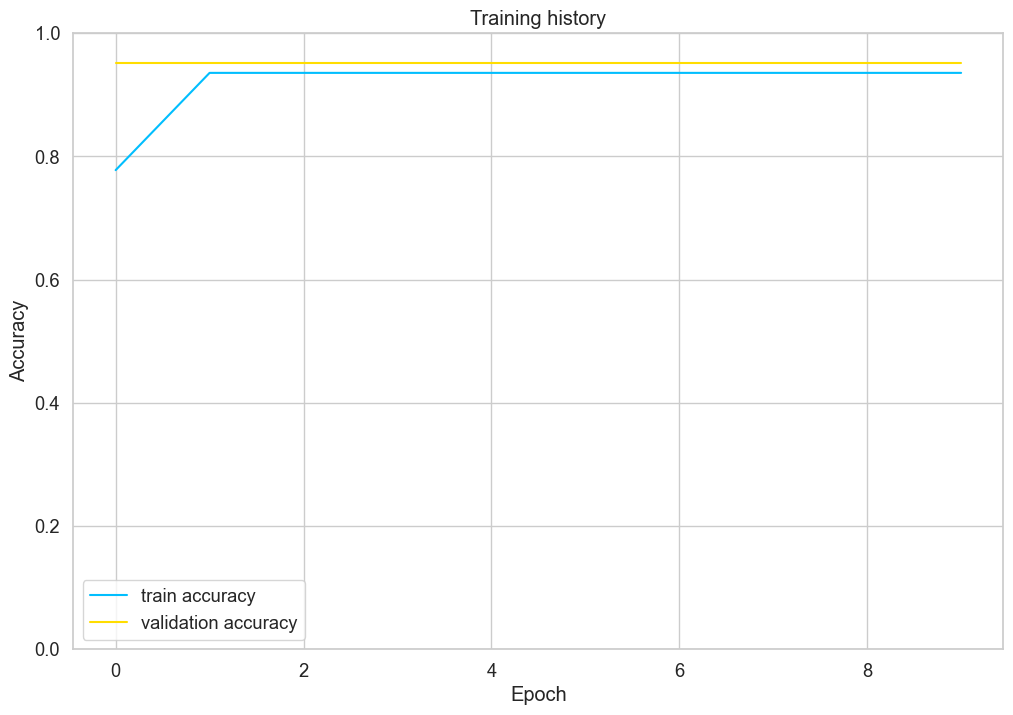

In [138]:
# Plot training and validation accuracy
plt.plot(
    [acc.detach().cpu().item() for acc in history["train_acc"]],
    label='train accuracy'
    )
plt.plot(
    [acc.detach().cpu().item() for acc in history["val_acc"]],
    label='validation accuracy'
    )

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [139]:
## model evaluation
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

acc_value = test_acc.detach().cpu().item()
print(f"Test acc: {acc_value:.4f}")

Test acc: 0.9545


In [140]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [141]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_dataloader
)

In [142]:
print(classification_report(y_test, y_pred, target_names=class_names))

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

## Walkthrough of Fine-Tuning BERT with PyTorch for Sentiment Analysis

In [86]:
## set up the data again
# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

df = pd.read_csv(r"C:\Users\Philippa\Documents\GitHub\webscraper\Scraper\NL_Parsed_Reviews.csv")

reviews_df = df.copy()
reviews_df

,name,date,rating,review
0,Ughduty,"Jun 19, 2025",7,Never played the game. Metacritic assigned my ...
1,tarquinthegreat,"Apr 28, 2025",10,absolutely banging ‎xxxxxxxxxxxxxxxxxxxxxxxxxx...
2,Gamewing,"Apr 21, 2025",6,"First couple hours are fun, getting your first..."
3,Z4ry,"Mar 24, 2025",9,100+ hours\n- Great evolution from previous ti...
4,Lucaq,"Mar 20, 2025",10,Perfect in every way.\nAaaaaaaaaaaaaaaaaaaaaaa...
...,...,...,...,...
209,Autosaver,"Jun 9, 2013",10,Animal Crossing has gone a long way since the ...
210,KirkyDaTurkey,"Jun 9, 2013",9,"Based on Day 1, this game is definitely a 9 so..."
211,EFYevan,"Jun 9, 2013",10,Much different than the previous DS version I...
212,L0stR3negade,"Jun 9, 2013",9,Refreshing style of game to play. Its hard to ...


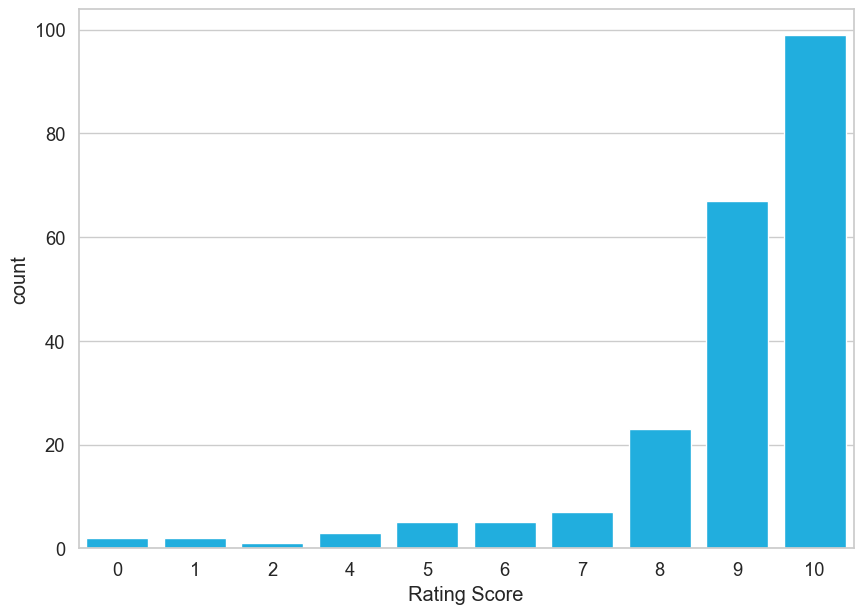

In [34]:
plt.figure(figsize=(10,7))
sns.countplot(reviews_df, x="rating")
plt.xlabel("Rating Score")
plt.show()

In [87]:
# merge the data together to get sentiment scores
def get_sentiment(rating):
    if rating <= 4:
        return 0 # negative sentiment
    elif rating == 5 or rating == 6:
        return 1 # neutral sentiment
    else:
        return 2 # positive sentiment
    
reviews_df["sentiment"] = reviews_df["rating"].apply(get_sentiment)
reviews_df.head()

,name,date,rating,review,sentiment
0,Ughduty,"Jun 19, 2025",7,Never played the game. Metacritic assigned my ...,2
1,tarquinthegreat,"Apr 28, 2025",10,absolutely banging ‎xxxxxxxxxxxxxxxxxxxxxxxxxx...,2
2,Gamewing,"Apr 21, 2025",6,"First couple hours are fun, getting your first...",1
3,Z4ry,"Mar 24, 2025",9,100+ hours\n- Great evolution from previous ti...,2
4,Lucaq,"Mar 20, 2025",10,Perfect in every way.\nAaaaaaaaaaaaaaaaaaaaaaa...,2


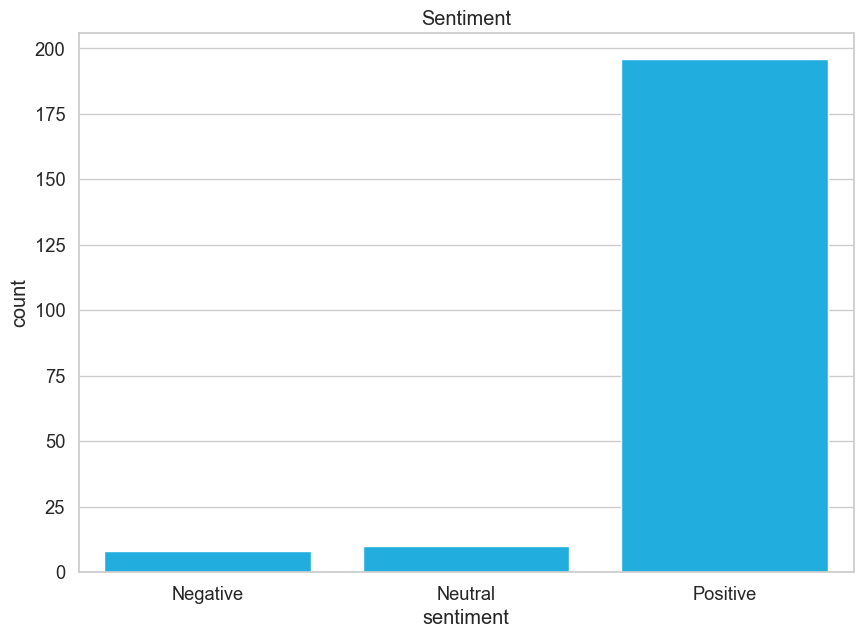

In [37]:
plt.figure(figsize=(10,7))
sns.countplot(reviews_df, x="sentiment")
plt.xticks([0, 1 ,2], ["Negative", "Neutral", "Positive"])
plt.title("Sentiment")
plt.show()

### BERT Tokenizer

Training a BERT model for sentiment analysis, a classification task in this case, the model will expect 2 inputs: token ids and attention masks.

The hugging face library provides many functions that will handle these inputs.

* Token IDs: an integar that represents a particular token.
* Attention mask: A sequence of ones and zeroes to let the model know which token comes from an input sentence (segment ID = 1) and which are just a padding token (segment ID = 0).
* Padding: When training BERT models, every input for the model needs to have the same size and same length of inputs to avoid any errors with back propagation. Padding enables the reviews to become the same size.

In [88]:
bert_model_name = "bert-base-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)

# demonstrating the BERT tokenizer
sample_text = "truly one of the best games on the 3Ds, i remember when i first picked this game up in 2013 i continued playing consistently for almost 5 years and i still find myself checking in on my villagers!"

tokens = tokenizer.tokenize(sample_text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"{sample_text}")
print("="*60)
print(tokens)
print("="*60)
print(ids)

truly one of the best games on the 3Ds, i remember when i first picked this game up in 2013 i continued playing consistently for almost 5 years and i still find myself checking in on my villagers!
['truly', 'one', 'of', 'the', 'best', 'games', 'on', 'the', '3D', '##s', ',', 'i', 'remember', 'when', 'i', 'first', 'picked', 'this', 'game', 'up', 'in', '2013', 'i', 'continued', 'playing', 'consistently', 'for', 'almost', '5', 'years', 'and', 'i', 'still', 'find', 'myself', 'checking', 'in', 'on', 'my', 'villagers', '!']
[5098, 1141, 1104, 1103, 1436, 1638, 1113, 1103, 7860, 1116, 117, 178, 2676, 1165, 178, 1148, 3015, 1142, 1342, 1146, 1107, 1381, 178, 1598, 1773, 10887, 1111, 1593, 126, 1201, 1105, 178, 1253, 1525, 1991, 9444, 1107, 1113, 1139, 12453, 106]


In [39]:
## Common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows it's classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


Hugging face library provides another function called `tokenizer.encode_plus()`, which will be used to perform most of the preprocessing steps in one go.

It will:
* Convert reviews into tokens
* Add [CLS] tokens at the beginning of the input
* Performs padding if sequence length is less than max_len
* Performs truncation if sequence length is greather than max_len
* Adds [SEP] token at the end of the sequence

In [48]:
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [45]:
print(encoding["input_ids"].shape)
encoding["input_ids"]

torch.Size([1, 43])


tensor([[  101,  5098,  1141,  1104,  1103,  1436,  1638,  1113,  1103,  7860,
          1116,   117,   178,  2676,  1165,   178,  1148,  3015,  1142,  1342,
          1146,  1107,  1381,   178,  1598,  1773, 10887,  1111,  1593,   126,
          1201,  1105,   178,  1253,  1525,  1991,  9444,  1107,  1113,  1139,
         12453,   106,   102]])

In [46]:
print(encoding["attention_mask"].shape)
encoding["attention_mask"]

torch.Size([1, 43])


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

### Deciding `max_len`

<Figure size 1000x700 with 0 Axes>

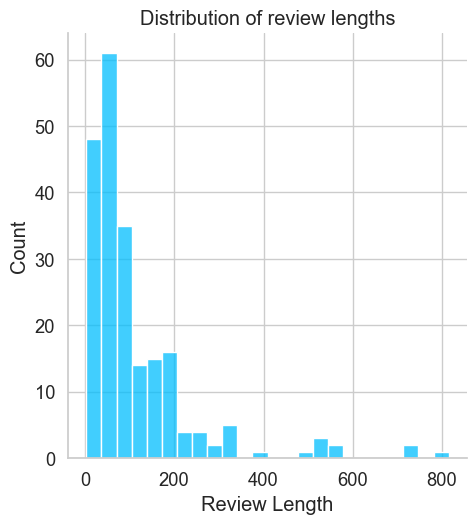

In [49]:
# max length of sequence
lengths = np.array([len(x.split()) for x in reviews_df.review])
plt.figure(figsize=(10,7))
sns.displot(lengths)
plt.xlabel("Review Length")
plt.title("Distribution of review lengths")
plt.show()

Optimal max length can be set to around 400. The max_len value should be set to a number that covers most of the reviews without truncation.

### Training, Test, and Validation Test Split

In [89]:
# 80% of data will be used for training the model, remaining 20% will be divided equally between validation and testing data
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(reviews_df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)

print(train_df.shape, test_df.shape, val_df.shape)

(171, 5) (22, 5) (21, 5)


In [ ]:
class MetaCriticReview(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, index):
        review = str(self.review[index])
        target = self.target[index]
        
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=400,
            truncation=True,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        return {"review_text": review,
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
                "targets": torch.tensor(target, dtype=torch.long)
                }

In [63]:
## Create class variable training data, validation data, and test data
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
MAX_LEN = 400

training_data = MetaCriticReview(review = train_df.review.to_numpy(),
                                 target = train_df.sentiment.to_numpy(),
                                 tokenizer = tokenizer,
                                 max_len = MAX_LEN)

validation_data = MetaCriticReview(review = val_df.review.to_numpy(),
                                   target = val_df.sentiment.to_numpy(),
                                   tokenizer=tokenizer,
                                   max_len=MAX_LEN)

test_data = MetaCriticReview(review = test_df.review.to_numpy(),
                             target = test_df.sentiment.to_numpy(),
                             tokenizer=tokenizer,
                             max_len=MAX_LEN)

In [59]:
print(len(training_data), len(validation_data), len(test_data))

171 21 22


In [64]:
# DataLoader
BATCH_SIZE = 5
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [65]:
sample_batch = next(iter(train_loader))
sample_batch.keys()

dict_keys(['review', 'input_id', 'attention_mask', 'target'])

In [66]:
print(sample_batch["review"][0])
print(sample_batch["input_id"][0])
print(sample_batch["attention_mask"][0])
print(sample_batch["target"][0])
print("="*50)
print(sample_batch["input_id"].shape, sample_batch["attention_mask"].shape, sample_batch["target"].shape)

Animal Crossing New Leaf is an enjoyable and adorable game, mimicking real life actions and routines, with fun, and creative fictional animal based-characters to interact and talk with. It's an addicting game and is for every age; without including violence.
tensor([  101, 10854, 16188,  1203, 21901,  1110,  1126, 24815,  1105, 27627,
         1342,   117, 27180,  4419,  1842,  1297,  3721,  1105, 27393,   117,
         1114,  4106,   117,  1105,  6228,  6725,  3724,  1359,   118,  2650,
         1106, 12254,  1105,  2037,  1114,   119,  1135,   112,   188,  1126,
         5194, 17882,  1158,  1342,  1105,  1110,  1111,  1451,  1425,   132,
         1443,  1259,  4289,   119,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

In [69]:
# Load BERT base model

bert_model_name = "bert-base-cased"
bert_model = BertModel.from_pretrained(bert_model_name)

# test the output of bert model
X = bert_model(sample_batch["input_id"].view(BATCH_SIZE, MAX_LEN),
               sample_batch["attention_mask"].view(BATCH_SIZE, MAX_LEN))

print("Last hidden layer size for input as batch", X[0].shape)
print("Pooled output size for input as batch", X[1].shape)

Last hidden layer size for input as batch torch.Size([5, 400, 768])
Pooled output size for input as batch torch.Size([5, 768])


In [70]:
## Build model
# pass input into the model --> review ids and attention mask
class SentimentClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        temp = self.bert(input_ids, attention_mask)
        pooled_output = temp[1]
        out = self.dropout(pooled_output)
        out = self.linear(out)
        return out

In [72]:
num_classes = 3
model = SentimentClassifier(num_classes)

sample_linear_output = model(sample_batch["input_id"],
                             sample_batch["attention_mask"])

s = nn.Softmax(dim=1)
final_out = s(sample_linear_output)
final_out, final_out.shape

(tensor([[0.2936, 0.2559, 0.4505],
         [0.5294, 0.1755, 0.2951],
         [0.2544, 0.2626, 0.4831],
         [0.2652, 0.2556, 0.4791],
         [0.1992, 0.3348, 0.4660]], grad_fn=<SoftmaxBackward0>),
 torch.Size([5, 3]))

Now that the sample batch has shown that the model works, I can define the loss function, optimizer, and scheduler (modifies the learning rate after each iteration to speed up convergence.)

In [75]:
# loss and optimizer 
EPOCHS = 20
total_steps = len(train_loader) * EPOCHS

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = transformers.Adafactor(params=model.parameters(), lr=0.01, relative_step=False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer=optimizer,
                                                         num_warmup_steps=0,
                                                         num_training_steps=total_steps)

In [83]:
def train_model(model, 
                data_loader,
                loss_fn,
                optimizer,
                scheduler,
                BATCH_SIZE,
                MAX_LEN,
                n_examples):
    
    # put model in training mode
    model.train()
    train_loss = []
    correct_pred = 0
    
    for d in data_loader:
        input_ids = d["input_id"]
        attention_masks = d["attention_mask"]
        targets = d["target"]
        
        # forward pass
        preds = model(input_ids, attention_masks)
        loss = loss_fn(preds, targets)
        _, pred_classes = torch.max(preds, dim=1)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # training loss and number of correct predictions
        train_loss.append(loss.item())
        correct_pred += torch.sum(pred_classes==targets)
        
    return correct_pred / n_examples, np.mean(train_loss)

In [84]:
def eval_model(model,
               data_loader,
               loss_fn,
               BATCH_SIZE,
               MAX_LEN,
               n_examples):
    model.eval()
    eval_loss = []
    correct_pred = 0
    
    with torch.inference_mode():
        for d in data_loader:
            input_ids = d["input_id"]
            attention_masks = d["attention_mask"]
            targets = d["target"]
            
            # forward pass
            preds = model(input_ids, attention_masks)
            loss = loss_fn(preds, targets)
            _, pred_classes = torch.max(preds, dim=1)
            
            eval_loss.append(loss.item())
            correct_pred += torch.sum(pred_classes==targets)
            
    return correct_pred / n_examples, np.mean(eval_loss)